In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sys import path
%matplotlib inline

In [2]:
%cd /content/drive/MyDrive/PHI/ToF_ML/src

/content/drive/MyDrive/PHI/ToF_ML/src


In [3]:
from ast import literal_eval
df = pd.read_csv('../data/full_corrected_data.csv')
df['channels']  = df['channels'].apply(literal_eval)
df['intensities'] = df['intensities'].apply(literal_eval)
df['masses'] = df['masses'].apply(literal_eval)

In [4]:
df.dropna(inplace=True)
df = df[df['intensities'].apply(len)> 0].copy()
df.head()

,file_name,MassOverTime,MassOffset,StartFlightTime,SpecBinSize,channels,intensities,masses,adjusted_original_proportion_identified,avg_dist_frags_low,avg_dist_frags_high,adjusted_proportion_identified,proportion_identified,diff,prop_diff_in_low,calibration
0,0106301.cas,0.387384,-0.275004,0.0,1.248,"[2644.0367300000003, 3505.0183700000002, 4162....","[73874, 1234, 138, 610, 1216, 4159, 8958, 1084...","[1.0065519723918102, 2.015029094672708, 3.0191...",0.398438,0.001298,0.002255,0.515625,0.515625,0.000958,0.738174,0
1,0107316.cas,0.387113,-0.278302,0.0,1.248,"[2647.00072, 3508.9949100000003, 4164.59326000...","[49864, 1034, 168, 4696, 8247, 13992, 17903, 2...","[1.00101811517532, 2.0077555328930656, 3.00565...",0.129771,0.001537,0.002586,0.511450,0.511450,0.001049,0.682225,0
2,0110203.cas,0.379037,-0.271056,0.0,4.992,"[1973.87665, 2049.0706800000003, 2122.01224, 2...","[23352, 74717, 10387, 947, 12344, 9121, 249, 4...","[11.998071176139083, 13.003971096434277, 14.01...",0.388889,0.001640,0.001858,0.444444,0.444444,0.000218,0.133100,0
3,0110212.cas,0.379177,-0.269744,0.0,4.992,"[672.00298, 891.90543, 1970.94521, 2046.11295,...","[34398, 304, 2223, 3521, 5205, 6509, 99, 115, ...","[1.0045194511091773, 2.012140966655108, 11.978...",0.379630,0.001337,0.002206,0.592593,0.592593,0.000868,0.649178,0
4,0116511.cas,0.383360,-0.302184,0.0,1.248,"[2726.98153, 3594.53649, 4265.28736, 7866.5038...","[42995, 602, 151, 17912, 9536, 17609, 29604, 5...","[1.0049940659400325, 2.0094784706009245, 3.022...",0.350427,0.001397,0.002171,0.487179,0.467213,0.000774,0.554114,0


In [5]:
from data_transformation import get_frags
from data_transformation import mass_formula
frags = get_frags()['FragmentMass']

In [6]:
df[df['file_name']=='Liver Tissue_Doped_Neg.cas']

,file_name,MassOverTime,MassOffset,StartFlightTime,SpecBinSize,channels,intensities,masses,adjusted_original_proportion_identified,avg_dist_frags_low,avg_dist_frags_high,adjusted_proportion_identified,proportion_identified,diff,prop_diff_in_low,calibration
1162,Liver Tissue_Doped_Neg.cas,0.382996,-0.690829,0.0,0.138,"[32055.48788, 39921.86337, 78607.0, 78649.9386...","[26537.0, 331.0, 1642.0, 228.0, 2567.0, 4023.0...","[1.0068434485385331, 2.014075900769189, 11.998...",0.359551,0.001158,0.001701,0.511236,0.444988,0.000543,0.468474,0


In [7]:
df.columns

Index(['file_name', 'MassOverTime', 'MassOffset', 'StartFlightTime',
       'SpecBinSize', 'channels', 'intensities', 'masses',
       'adjusted_original_proportion_identified', 'avg_dist_frags_low',
       'avg_dist_frags_high', 'adjusted_proportion_identified',
       'proportion_identified', 'diff', 'prop_diff_in_low', 'calibration'],
      dtype='object')

In [132]:
test = test_df.loc[4]

In [40]:
def mass_formula(channels: np.array, spec_bin_size, start_time,  mass_over_time, mass_offset):
    '''
    Fast conversion from flightime to mass.
    '''
    return ((channels * .001 * spec_bin_size + start_time) * mass_over_time + mass_offset)**2

In [48]:
def get_100amu_channel(spec_bin_size, start_time,  mass_over_time, mass_offset):
    return (((10 - mass_offset) / mass_over_time) - start_time) * 1 / (.001 * spec_bin_size)

In [280]:
def generate_data(data, tens, modifier, ranges=[0.2, 0.4, .6],
                  multi_class=False, slope_cat=False, sub_one=False,
                  precision=.003, slope_mods=False, slope_modifiers=[3, 2]):
    '''
    Takes calibrated ToF-MS data and adds error to the offset and mass.
    Returns multiclass classification dataset 0: no error,
    1: offset error, 2: slope error, 3: both. Does not recalibrate with new 
    slope and offset values

    Arguments -------
    data: dataframe to add error to
    tens: power of tens place for error
    modifier: modifier to apply to error, eg (rand num) / modifier
    ranges: percentile ranges for different outcomes slope error, offset
    and slope error, offset error
    slope_cat: if true both and slope error are in same the category of target.
    sub_one: sub one argument for add error, whetehr to subtract from 1, flips
    range when modifier is greater than 1.
    slope_mods: boolean to indicate that a different set of modifiers should be
                used to calculate slope
    slope_modifiers: a 2 element list contianing [tens, modifier] for slope
    '''
    err_data = data.copy()
    target = []
    error_percent_slope = []
    error_percent_offset = []
    err_amt = []
    new_slope = []
    new_offset = []
    for row in err_data.itertuples():
        chan_100 = get_100amu_channel(row.SpecBinSize, row.StartFlightTime,
                                      row.MassOverTime, row.MassOffset)
        init_100 = mass_formula(np.array(chan_100), row.SpecBinSize,
                                row.StartFlightTime, row.MassOverTime,
                                row.MassOffset)
        
        num = np.random.rand(1)
        if num < ranges[0]: #slope only
            ten = tens
            mod = modifier
            if slope_mods:
                ten = slope_modifiers[0]
                mod = slope_modifiers[1]

            slope, sl_err = add_error(row.MassOverTime, tens=ten, modifier=mod, sub_one=sub_one)
            error_percent_slope.append(sl_err)
            new_slope.append(slope)
            new_offset.append(row.MassOffset)
            error_percent_offset.append(0)
            new_100 = mass_formula(np.array(chan_100), row.SpecBinSize,
                                row.StartFlightTime, slope,
                                row.MassOffset)
            diff_100 = init_100 - new_100
            err_amt.append(diff_100)
            if abs(diff_100) > precision:
                if multi_class:
                    target.append(2)
                else:
                    target.append(1)
            else:
                target.append(0)
        elif num >= ranges[0] and num < ranges[1]: # both
            ten = tens
            mod = modifier
            if slope_mods:
                ten = slope_modifiers[0]
            offset, off_err = add_error(row.MassOffset, tens=tens, modifier=modifier, sub_one=sub_one)
            error_percent_offset.append(off_err)
            new_offset.append(offset)
            slope, sl_err = add_error(row.MassOverTime, tens=ten, modifier=mod, sub_one=sub_one)
            error_percent_slope.append(sl_err)
            new_slope.append(slope)
            new_100 = mass_formula(np.array(chan_100), row.SpecBinSize,
                                row.StartFlightTime, slope, offset)
            diff_100 = init_100 - new_100
            err_amt.append(diff_100)
            if abs(diff_100) > precision:
                if multi_class:
                    if slope_cat:
                        target.append(2)
                    else:
                        target.append(3)
                else:
                    target.append(1)
            else:
                target.append(0)
        elif num >= ranges[1] and num < ranges[2]: # offset only
            error_percent_slope.append(0)
            offset, off_err = add_error(row.MassOffset, tens=tens, modifier=modifier, sub_one=sub_one)
            error_percent_offset.append(off_err)
            new_offset.append(offset)
            new_slope.append(row.MassOverTime)
            new_100 = mass_formula(np.array(chan_100), row.SpecBinSize,
                                row.StartFlightTime, row.MassOverTime,
                                offset)
            diff_100 = init_100 - new_100
            err_amt.append(diff_100)
            if abs(diff_100) > precision:
                target.append(1)
            else:
                target.append(0)
        else: # none
            target.append(0)
            error_percent_slope.append(0)
            error_percent_offset.append(0)
            err_amt.append(0)
            new_slope.append(row.MassOverTime)
            new_offset.append(row.MassOffset)    
        
    err_data['target'] = target
    err_data['err_prop_slope'] = error_percent_slope
    err_data['err_prop_offset'] = error_percent_offset
    err_data['err_at_100amu'] = err_amt
    err_data['MassOverTime'] = new_slope
    err_data['MassOffset'] = new_offset
    return err_data

In [286]:
from data_transformation import generate_calibrated_data
placeholder = df[['file_name', 'MassOverTime', 'MassOffset', 'StartFlightTime',
       'SpecBinSize', 'channels', 'intensities', 'masses']].copy()
erred = generate_data(placeholder, 4.1, 2, [0, 1, 0], sub_one=False,
                      slope_mods=True, slope_modifiers=[5.1, 2])
for num in range(1):
    for _ in range(3):
        erred = pd.concat([erred, generate_data(placeholder, num + 2, 1,
                                                [0.2, .6, 1], True,
                                                True)], axis=0)
erred.reset_index(inplace=True, drop=True)
erred = generate_calibrated_data(erred)

In [287]:
np.mean(abs(erred[erred['target']==0]['err_at_100amu']))

0.00041999692181071783

In [288]:
np.mean(abs(erred[erred['target']==1]['err_at_100amu']))

0.08833975825561176

In [289]:
erred.head()

,file_name,MassOverTime,MassOffset,StartFlightTime,SpecBinSize,channels,intensities,masses,target,err_prop_slope,err_prop_offset,err_at_100amu
0,0106301.cas,0.387383,-0.274995,0.0,1.248,"[2644.0367300000003, 3505.0183700000002, 4162....","[73874, 1234, 138, 610, 1216, 4159, 8958, 1084...","[1.0065622793103886, 2.0150395261948186, 3.019...",0,-3.513135e-06,-0.000035,0.000529
1,0107316.cas,0.387112,-0.278304,0.0,1.248,"[2647.00072, 3508.9949100000003, 4164.59326000...","[49864, 1034, 168, 4696, 8247, 13992, 17903, 2...","[1.0010098642004572, 2.0077416523479825, 3.005...",0,-1.860124e-06,0.000006,0.000417
2,0110203.cas,0.379037,-0.271048,0.0,4.992,"[1973.87665, 2049.0706800000003, 2122.01224, 2...","[23352, 74717, 10387, 947, 12344, 9121, 249, 4...","[11.998122464163478, 13.004024192327336, 14.01...",0,-2.912035e-07,-0.000031,-0.000110
3,0110212.cas,0.379178,-0.269736,0.0,4.992,"[672.00298, 891.90543, 1970.94521, 2046.11295,...","[34398, 304, 2223, 3521, 5205, 6509, 99, 115, ...","[1.0045398899200675, 2.0121726528039634, 11.97...",0,2.336412e-06,-0.000027,-0.000624
4,0116511.cas,0.383359,-0.302176,0.0,1.248,"[2726.98153, 3594.53649, 4265.28736, 7866.5038...","[42995, 602, 151, 17912, 9536, 17609, 29604, 5...","[1.0050061650120452, 2.0094940677874633, 3.022...",0,-1.284279e-06,-0.000026,0.000110


In [290]:
sum(erred['target'])

14842

In [291]:
from data_transformation import recalibrate
def get_cols(data, amt, frags, err=False):
    n = 1
    if err:
        n = 3
    cols = [[[] for num in range(n)] for num in range(4)]
    for i, row in enumerate(data.itertuples()):
        a, b, c, d = recalibrate(row, frags, 0, 0, num_peaks=True)
        cols[0][0].append(a)
        cols[1][0].append(b)
        cols[2][0].append(c)
        cols[3][0].append(d)
        if err:
            for i, num in enumerate([1, -1]):
                a, b, c, d = recalibrate(row, frags, 0, amt * num, num_peaks=True)
                cols[0][i + 1].append(a)
                cols[1][i + 1].append(b)
                cols[2][i + 1].append(c)
                cols[3][i + 1].append(d)
    return cols

In [292]:
cols = get_cols(erred, .0005, frags,  err=True)

In [293]:
from data_transformation import (get_isotope_data, get_ranges,
                                 get_suspicious_peaks, get_peak_suspiciousness)
isotopes = get_isotope_data()
ranges = get_ranges(isotopes['Isotope Masses'], 2000)
suspicious_peaks = erred['masses'].apply(get_suspicious_peaks, args=(ranges, ))
num_sus_peaks = pd.Series(suspicious_peaks).apply(len)
prop_sus_peaks = num_sus_peaks / erred['masses'].apply(len)
peak_susses =  erred['masses'].apply(get_peak_suspiciousness, args=(ranges, ))
avg_peak_sussness = pd.Series(peak_susses).apply(np.mean)

In [294]:
from sklearn.model_selection import train_test_split
d = { 'Miscalibrated': erred['target'],'Proportion Assigned': cols[0][0],
     'Low Distance From Fragment': cols[1][0],
     'High Distance From Fragment': cols[2][0],
     'Peaks Matched' : cols[3][0],
     'Diff Proportion w/ Offset Added': -1 * (np.array(cols[0][0]) - np.array(cols[0][1])),
     'Low Distance w/ Offset Added':   (np.array(cols[1][0]) - np.array(cols[1][1])),
     'High Distance w/ Offset Added':  (np.array(cols[2][0]) - np.array(cols[2][1])),
     'Peaks Matched Offset Added' :  -1 *( np.array(cols[3][0]) - np.array(cols[3][1])),
     'Proportion w/ Offset Subbed':   -1 * (np.array(cols[0][0]) - np.array(cols[0][2])),
     'Low Distance w/ Offset Subbed':  (np.array(cols[1][0]) - np.array(cols[1][2])),
     'High Distance w/ Offset Subbed':  (np.array(cols[2][0]) - np.array(cols[2][2])),
     'Peaks Matched Offset Subbed' :  -1 * (np.array(cols[3][0]) - np.array(cols[3][2])), 
     'Number of NPZ Peaks': num_sus_peaks, 
     'Proportion of NPZ Peaks': prop_sus_peaks,
     'Average Distance into NPZ': avg_peak_sussness}

training_data = pd.DataFrame(d)

In [240]:
training_data.to_csv('../data/training_datawbinaryclass.0005.csv')

In [258]:
training_data = pd.read_csv('../data/training_datawbinaryclass.0005.csv')
training_data.drop(['Unnamed: 0'], axis=1, inplace=True)
training_data['Miscalibrated'] = training_data['Miscalibrated'].apply(lambda x: 0 if x == 0 else 1)
training_data.head()

,Miscalibrated,Proportion Assigned,Low Distance From Fragment,High Distance From Fragment,Peaks Matched,Diff Proportion w/ Offset Added,Low Distance w/ Offset Added,High Distance w/ Offset Added,Peaks Matched Offset Added,Proportion w/ Offset Subbed,Low Distance w/ Offset Subbed,High Distance w/ Offset Subbed,Peaks Matched Offset Subbed,Number of NPZ Peaks,Proportion of NPZ Peaks,Average Distance into NPZ
0,0,0.492188,0.001232,0.002245,63,-0.046875,-0.000133,-0.000495,-6,-0.039062,0.000033,-0.000267,-5,0,0.000000,0.002474
1,0,0.480916,0.001277,0.002403,63,-0.038168,-0.000033,-0.000147,-5,-0.022901,0.000152,0.000010,-3,5,0.038168,0.009842
2,0,0.444444,0.001662,0.001895,8,0.055556,-0.000036,0.000198,1,-0.111111,0.000123,-0.000567,-2,0,0.000000,0.002994
3,0,0.555556,0.001330,0.002387,60,-0.037037,0.000171,0.000233,-4,-0.120370,0.000195,-0.000411,-13,0,0.000000,0.001155
4,0,0.487179,0.001408,0.002184,57,-0.059829,0.000412,0.000054,-7,-0.085470,0.000175,-0.000409,-10,3,0.024590,0.005727


In [314]:
training_data['Miscalibrated'].describe()

count    13380.000000
mean         1.109268
std          0.877685
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: Miscalibrated, dtype: float64

In [296]:
corr_df = training_data.copy()
corr_df = pd.concat([corr_df], axis=1)
#corr_df = pd.concat([corr_df, pd.get_dummies(corr_df['Miscalibrated'])], axis=1)

In [297]:
training_data.columns

Index(['Miscalibrated', 'Proportion Assigned', 'Low Distance From Fragment',
       'High Distance From Fragment', 'Peaks Matched',
       'Diff Proportion w/ Offset Added', 'Low Distance w/ Offset Added',
       'High Distance w/ Offset Added', 'Peaks Matched Offset Added',
       'Proportion w/ Offset Subbed', 'Low Distance w/ Offset Subbed',
       'High Distance w/ Offset Subbed', 'Peaks Matched Offset Subbed',
       'Number of NPZ Peaks', 'Proportion of NPZ Peaks',
       'Average Distance into NPZ'],
      dtype='object')

In [298]:
corr_df.columns = ['Miscalibrated', 'Proportion Assigned', 'Low Distance From Fragment',
       'High Distance From Fragment', 'Peaks Matched',
       'Diff Proportion w/ Offset Added', 'Low Distance w/ Offset Added',
       'High Distance w/ Offset Added', 'Peaks Matched Offset Added',
       'Proportion w/ Offset Subbed', 'Low Distance w/ Offset Subbed',
       'High Distance w/ Offset Subbed', 'Peaks Matched Offset Subbed',
       'Number of NPZ Peaks', 'Proportion of NPZ Peaks',
       'Average Distance into NPZ']#, 'No Error','Offset Error',
        #    'Slope Error']

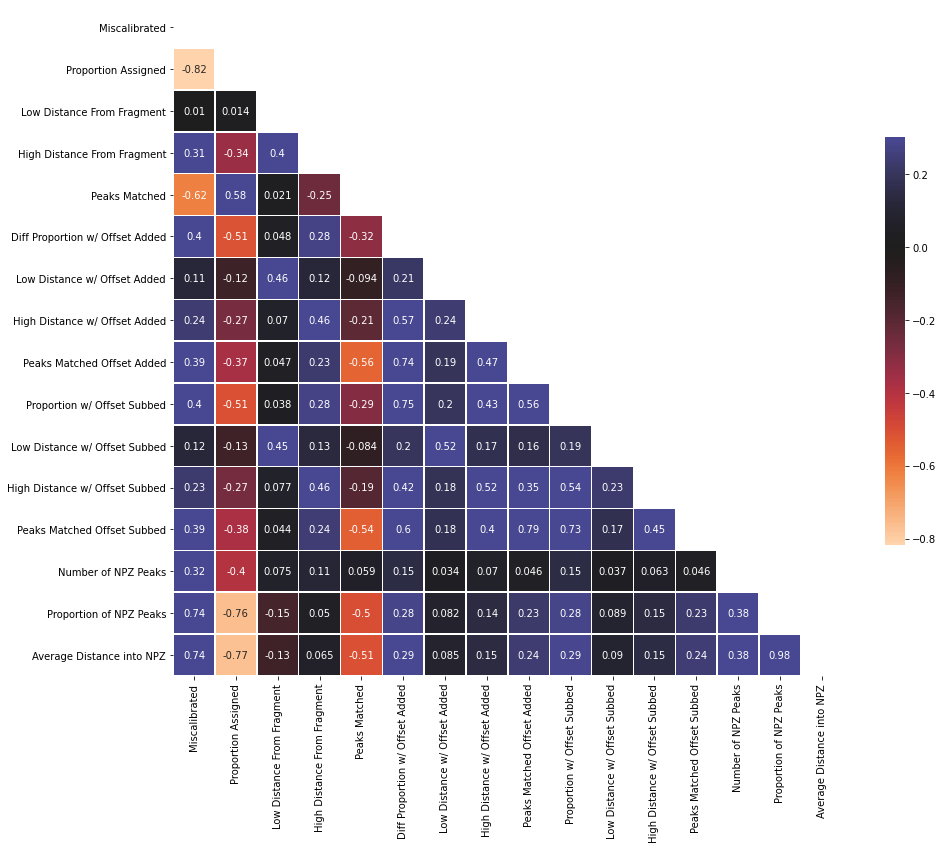

In [299]:
corr = corr_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap='icefire_r',mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True, ax=ax, cbar_kws={"shrink": 0.5})
corr_df=None

In [300]:
from sklearn.model_selection import train_test_split
X = training_data.drop('Miscalibrated', axis=1)
#y = erred['target']
y = training_data['Miscalibrated']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [301]:
class_weights = {0 : 1 / (np.sum(training_data['Miscalibrated'] == 0) / len(training_data)),
                 1 : 1 / (np.sum(training_data['Miscalibrated'] == 1) / len(training_data))}
class_weights

{0: 2.972012438916037, 1: 4.5916266300617705}

In [302]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rfc = RandomForestClassifier(class_weight=class_weights)
parameters = {'criterion':('gini', 'entropy'), 'n_estimators':[75, 150], 'max_depth':[3, 31]}
clf_rfc = GridSearchCV(rfc, parameters)
clf_rfc.fit(X_train, y_train)
print('Test Score: ' + str(clf_rfc.score(X_test, y_test)))
print('Train Score: ' + str(clf_rfc.score(X_train, y_train)))

Test Score: 0.9047085201793722
Train Score: 1.0


In [313]:
preds_rfc = clf_rfc.predict(X_test)
wrong_rfc = X_test.loc[y_test!= preds_rfc].copy()
wrong_rfc['target'] = y_test[y_test!= preds_rfc]
wrong_rfc['Predicted'] = preds_rfc[y_test!= preds_rfc]
wrong_rfc.head()

,Proportion Assigned,Low Distance From Fragment,High Distance From Fragment,Peaks Matched,Diff Proportion w/ Offset Added,Low Distance w/ Offset Added,High Distance w/ Offset Added,Peaks Matched Offset Added,Proportion w/ Offset Subbed,Low Distance w/ Offset Subbed,High Distance w/ Offset Subbed,Peaks Matched Offset Subbed,Number of NPZ Peaks,Proportion of NPZ Peaks,Average Distance into NPZ,target,Predicted
9282,0.119363,0.001372,0.002610,45,-0.037135,-0.000030,0.000230,-14,0.095491,0.000026,0.000295,36,23,0.047917,0.031533,2,1
8122,0.000000,0.000000,0.000000,0,-0.000000,0.000000,0.000000,0,-0.000000,0.000000,0.000000,0,77,0.810526,0.152889,1,2
9934,0.014577,0.001862,0.002230,5,-0.005831,0.001526,0.000253,-2,-0.008746,0.000727,0.001095,-3,474,0.757188,0.183582,1,2
4948,0.019108,0.001581,0.001581,3,-0.012739,0.000973,-0.001888,-2,-0.006369,-0.000274,-0.001531,-1,83,0.528662,0.167505,1,2
4480,0.016667,0.001137,0.004161,6,0.058333,-0.000184,0.001702,21,0.022222,-0.000282,0.001792,8,75,0.203804,0.061827,2,1


In [308]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(boosting_type ='dart', class_weight=class_weights)
parameters = {'learning_rate':[0.01, 0.2],
              'n_estimators':[90, 110], 'min_data_in_leaf':[250,800],
              'bagging_fraction':[0.6, 0.8], 'bagging_freq':[5, 15], 'feature_fraction':[0.7, 1]}
clf_lgbm = GridSearchCV(lgbm, parameters)
clf_lgbm.fit(X_train, y_train)
print('Test Score: ' + str(clf_lgbm.score(X_test, y_test)))
print('Train Score: ' + str(clf_lgbm.score(X_train, y_train)))

Test Score: 0.8934977578475336
Train Score: 0.9537556053811659


In [311]:
clf_lgbm.get_params()

{'cv': None,
 'error_score': nan,
 'estimator': LGBMClassifier(boosting_type='dart',
                class_weight={0: 2.972012438916037, 1: 4.5916266300617705},
                colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
                max_depth=-1, min_child_samples=20, min_child_weight=0.001,
                min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
                objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
                silent=True, subsample=1.0, subsample_for_bin=200000,
                subsample_freq=0),
 'estimator__boosting_type': 'dart',
 'estimator__class_weight': {0: 2.972012438916037, 1: 4.5916266300617705},
 'estimator__colsample_bytree': 1.0,
 'estimator__importance_type': 'split',
 'estimator__learning_rate': 0.1,
 'estimator__max_depth': -1,
 'estimator__min_child_samples': 20,
 'estimator__min_child_weight': 0.001,
 'estimator__min_split_gain': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_job

In [309]:
preds_lgbm = clf_lgbm.predict(X_test)
wrong_lgbm = X_test.loc[y_test!= preds_lgbm].copy()
wrong_lgbm['target'] = y_test[y_test!= preds_lgbm]
wrong_lgbm['Predicted'] = preds_lgbm[y_test!= preds_lgbm]
wrong_lgbm.head()

,Proportion Assigned,Low Distance From Fragment,High Distance From Fragment,Peaks Matched,Diff Proportion w/ Offset Added,Low Distance w/ Offset Added,High Distance w/ Offset Added,Peaks Matched Offset Added,Proportion w/ Offset Subbed,Low Distance w/ Offset Subbed,High Distance w/ Offset Subbed,Peaks Matched Offset Subbed,Number of NPZ Peaks,Proportion of NPZ Peaks,Average Distance into NPZ,target,Predicted
9282,0.119363,0.001372,0.002610,45,-0.037135,-0.000030,0.000230,-14,0.095491,0.000026,0.000295,36,23,0.047917,0.031533,2,1
7039,0.000000,0.000000,0.000000,0,-0.000000,0.000000,0.000000,0,-0.000000,0.000000,0.000000,0,79,0.858696,0.255856,2,1
5522,0.002959,0.000183,0.000183,1,0.002959,-0.001754,-0.001754,1,-0.000000,-0.000363,-0.000363,0,311,0.917404,0.276507,2,1
8122,0.000000,0.000000,0.000000,0,-0.000000,0.000000,0.000000,0,-0.000000,0.000000,0.000000,0,77,0.810526,0.152889,1,2
8768,0.162791,0.001568,0.001776,7,-0.069767,0.000649,-0.000713,-3,-0.046512,0.000849,-0.000080,-2,28,0.651163,0.179702,2,0


In [ ]:
len(wrong_lgbm)

695

In [ ]:
wrong_lgbm[wrong_lgbm['Predicted']==0]

,Proportion Assigned,Low Distance From Fragment,High Distance From Fragment,Peaks Matched,Diff Proportion w/ Offset Added,Low Distance w/ Offset Added,High Distance w/ Offset Added,Peaks Matched Offset Added,Proportion w/ Offset Subbed,Low Distance w/ Offset Subbed,High Distance w/ Offset Subbed,Peaks Matched Offset Subbed,Number of NPZ Peaks,Proportion of NPZ Peaks,Average Distance into NPZ,target,Predicted
10643,0.352459,0.001320,0.002349,86,-0.065574,0.000128,-0.000454,-16,-0.028689,0.000166,-0.000010,-7,53,0.217213,0.056773,1,0
11034,0.453488,0.001100,0.001633,117,-0.147287,-0.000098,-0.000754,-38,-0.201550,-0.000096,-0.001482,-52,6,0.023256,0.013147,1,0
4023,0.722222,0.000989,0.001178,143,-0.070707,-0.000205,-0.000562,-14,-0.080808,-0.000214,-0.000426,-16,7,0.025090,0.008252,1,0
8122,0.673684,0.001190,0.001781,64,-0.147368,-0.000171,-0.000936,-14,-0.031579,-0.000190,-0.000226,-3,0,0.000000,0.000089,1,0
7541,0.593525,0.001271,0.001938,165,-0.107914,-0.000110,-0.000533,-30,-0.287770,-0.000326,-0.001437,-80,0,0.000000,0.002009,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6193,0.773869,0.001068,0.001405,154,-0.266332,-0.000436,-0.001337,-53,-0.391960,-0.000375,-0.001664,-78,4,0.020101,0.005110,1,0
8495,0.742857,0.001374,0.001932,26,-0.114286,0.000104,-0.000356,-4,-0.171429,0.000376,-0.000261,-6,0,0.000000,0.001117,1,0
5701,0.538462,0.001551,0.002458,28,-0.115385,0.000221,-0.000377,-6,-0.096154,0.000401,0.000021,-5,0,0.000000,0.000723,1,0
12887,0.842365,0.000951,0.001162,171,-0.295567,-0.000546,-0.001365,-60,-0.463054,-0.000513,-0.002065,-94,4,0.019704,0.005178,1,0


In [ ]:
wrong_lgbm[wrong_lgbm['target']==0]

,Proportion Assigned,Low Distance From Fragment,High Distance From Fragment,Peaks Matched,Diff Proportion w/ Offset Added,Low Distance w/ Offset Added,High Distance w/ Offset Added,Peaks Matched Offset Added,Proportion w/ Offset Subbed,Low Distance w/ Offset Subbed,High Distance w/ Offset Subbed,Peaks Matched Offset Subbed,Number of NPZ Peaks,Proportion of NPZ Peaks,Average Distance into NPZ,target,Predicted
168,0.429293,0.001298,0.001773,85,-0.000000,9.252443e-08,6.370522e-08,0,-0.000000,-9.252443e-08,-6.370522e-08,0,44,0.196429,0.060484,0,1
410,0.574545,0.001240,0.002053,158,-0.000000,-1.494796e-08,-1.735710e-08,0,-0.000000,1.494796e-08,1.735711e-08,0,0,0.000000,0.004921,0,1
1844,0.401869,0.001395,0.002254,43,-0.000000,0.000000e+00,0.000000e+00,0,-0.000000,0.000000e+00,0.000000e+00,0,9,0.084112,0.019663,0,1
3080,0.493671,0.001205,0.002304,117,-0.000000,-5.955010e-09,3.354653e-08,0,-0.000000,-2.621355e-09,-3.912117e-08,0,0,0.000000,0.007537,0,1
1957,0.458333,0.001308,0.002223,121,-0.000000,0.000000e+00,0.000000e+00,0,-0.000000,0.000000e+00,0.000000e+00,0,5,0.018727,0.008265,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,0.521628,0.001360,0.002193,205,-0.015267,6.838400e-05,1.238374e-04,-6,-0.022901,5.140099e-05,-1.415736e-05,-9,5,0.012626,0.005938,0,1
1886,0.257143,0.000741,0.001626,9,-0.000000,0.000000e+00,0.000000e+00,0,-0.000000,0.000000e+00,0.000000e+00,0,7,0.200000,0.052368,0,1
1339,0.711712,0.001021,0.001388,79,-0.000000,-8.226840e-08,-8.740016e-08,0,-0.000000,8.226840e-08,8.740017e-08,0,1,0.008197,0.004255,0,1
3082,0.504000,0.001374,0.002082,189,-0.000000,9.561060e-08,6.953584e-08,0,-0.000000,-9.561061e-08,-6.953585e-08,0,13,0.034667,0.013110,0,1


In [ ]:
len(wrong_lgbm)

227